In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

In [48]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, Set2Set, GNNExplainer
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
import os

import matplotlib.pyplot as plt
from dgl.data import BACommunityDataset
import networkx as nx
import torch_geometric
import dgl


In [4]:
%cd C:\\Users\\Yurt\\Documents\\Cambridge\\GNN\\gnn_explainability

C:\Users\Yurt\Documents\Cambridge\GNN\gnn_explainability


In [49]:
from src.model import *
from src.data import *
from src.explainer import *
from src.plot import *
from src.modify import *
from src.protgnn import *

In [50]:
ba_dataset = get_dataset("BAShapes")

Done loading data from cached files.


C:\Users\Yurt\anaconda3\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [51]:
num_classes = len(set([int(i) for i in ba_dataset.y]))
num_features = ba_dataset.x.shape[-1]

In [52]:
epochs = 3000
dim = 20

## GCExplainer

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(num_features=num_features, dim=dim, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)


In [54]:
model = train_model(epochs,model,device,ba_dataset,optimizer,test_model)

[Train_loss:0.183871 Train_acc: 0.9768, Test_acc: 0.9214]: 100%|██████████████████| 3000/3000 [00:26<00:00, 114.31it/s]


In [11]:
gce_explainer = GCExplainer()

In [12]:
gce_explainer.learn_prototypes(model,ba_dataset)

C:\Users\Yurt\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Yurt\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [13]:
gce_explainer.get_prediction(model,ba_dataset)

array([2, 2, 1, 2, 3, 1, 2, 1, 1, 1, 0, 1, 3, 0, 0, 1, 2, 2, 1, 2, 1, 0,
       0, 2, 3, 2, 0, 1, 1, 1, 0, 0, 2, 2, 2, 1, 1, 1, 1, 2, 0, 1, 0, 0,
       1, 1, 2, 0, 2, 1, 1, 2, 0, 2, 1, 1, 2, 3, 1, 1, 0, 3, 1, 0, 2, 2,
       2, 2, 1, 2, 0, 0, 0, 1, 0, 1, 1, 3, 2, 1, 0, 0, 1, 2, 1, 1, 1, 2,
       1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 3], dtype=int64)

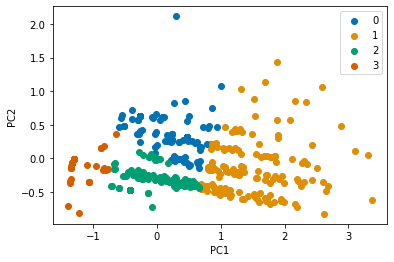

In [14]:
plot_kmeans_clusters(gce_explainer.kmeans,gce_explainer.initial_activations)

In [16]:
gce_explainer.get_prediction(model,identity(ba_dataset))

array([2, 2, 1, 2, 3, 1, 2, 1, 1, 1, 0, 1, 3, 0, 0, 1, 2, 2, 1, 2, 1, 0,
       0, 2, 3, 2, 0, 1, 1, 1, 0, 0, 2, 2, 2, 1, 1, 1, 1, 2, 0, 1, 0, 0,
       1, 1, 2, 0, 2, 1, 1, 2, 0, 2, 1, 1, 2, 3, 1, 1, 0, 3, 1, 0, 2, 2,
       2, 2, 1, 2, 0, 0, 0, 1, 0, 1, 1, 3, 2, 1, 0, 0, 1, 2, 1, 1, 1, 2,
       1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 3], dtype=int64)

## ProtGNN

In [17]:
model = GCNNet_NC(num_features, num_classes, model_args).to(device)

In [18]:
model.load_state_dict(torch.load("../models/protgnn_bashapes.pt"))

FileNotFoundError: [Errno 2] No such file or directory: '../models/protgnn_bashapes.pt'

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-3)

In [ ]:
model = train_model(300,model,device,ba_dataset,optimizer,test_model,get_outputs=lambda a: a[1])

In [ ]:
prot_explainer = ProtGNNExplainer()

In [ ]:
prot_explainer.learn_prototypes(model,ba_dataset)

In [ ]:
prot_explainer.get_prediction(model,ba_dataset)

## CDM

In [28]:
model = GCN(num_features=num_features, dim=dim, num_classes=num_classes)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-3)

In [34]:
model = train_model(epochs,model,device,ba_dataset,optimizer,test_model,get_outputs=lambda a: a[1])

[Train_loss:5.268274 Train_acc: 0.9839, Test_acc: 0.9143]: 100%|███████████████████| 3000/3000 [01:26<00:00, 34.73it/s]


In [35]:
cdm_explainer = CDMExplainer()

In [38]:
cdm_explainer.learn_prototypes(model, ba_dataset)

0
[]


In [40]:
cdm_explainer.get_prediction(model, ba_dataset)

700 20
Explanation class 0: ~feature0000000010 - acc. = 0.9214 - compl. = 1.0000
Explanation class 1: feature0000000006 - acc. = 0.9286 - compl. = 1.0000
Explanation class 2: ~feature0000000000 & ~feature0000000001 & ~feature0000000006 & ~feature0000000010 & ~feature0000000013 - acc. = 1.0000 - compl. = 5.0000
Explanation class 3: feature0000000000 - acc. = 0.8929 - compl. = 1.0000


{'0': {'explanation': '~feature0000000010',
  'explanation_accuracy': 0.9214285714285714,
  'explanation_complexity': 1},
 '1': {'explanation': 'feature0000000006',
  'explanation_accuracy': 0.9285714285714286,
  'explanation_complexity': 1},
 '2': {'explanation': '~feature0000000000 & ~feature0000000001 & ~feature0000000006 & ~feature0000000010 & ~feature0000000013',
  'explanation_accuracy': 1.0,
  'explanation_complexity': 5},
 '3': {'explanation': 'feature0000000000',
  'explanation_accuracy': 0.8928571428571429,
  'explanation_complexity': 1}}

In [42]:
print(ba_dataset)

Batch(x=[700, 1], edge_index=[2, 2055], y=[700], batch=[700], ptr=[2], train_mask=[700], test_mask=[700])


## Adversary Methods

In [ ]:
ba_adversary = aggressive_adversary(ba_dataset,0.1)

In [ ]:
ba_adversary.edge_index.int()

In [55]:
explainer = GNNExplainer(model, epochs=200)

In [56]:
node_feature_mask, edge_mask = explain_model(explainer,ba_dataset,10)

Explain node 10: 100%|██████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 497.28it/s]


In [59]:
print(node_feature_mask)

tensor([0.1525])
